# E-Commerce Shipping: 데이터 한계 극복과 공급망 최적화 전략

**팀 프로젝트 발표 자료 초안**

## 1. 프로젝트 개요 및 팀원 역할

본 프로젝트는 이커머스 배송 데이터를 분석하여 **배송 지연(Late Delivery)**을 예측하고, 이를 방지하기 위한 공급망 최적화 전략을 제안하는 것을 목표로 합니다.

### 4인 팀 역할 분담
1. **데이터 분석가 (Data Analyst)**: 데이터 특성 파악, 가설 수립 및 시각화 (인사이트 도출)
2. **데이터 엔지니어 (Data Engineer)**: 전처리 파이프라인 구축 및 파생 변수 생성
3. **머신러닝 모델러 (ML Modeler)**: 예측 모델 구축, 튜닝 및 성능 최적화 (AutoGluon 등 활용)
4. **프로젝트 매니저 & QA (PM & QA)**: 일정 및 코드 관리, 모델 검증 및 최종 산출물 통합

---

## 2. 초기 분석: ECS 데이터셋의 한계 (The Contentious Point)

우리는 초기 단계에서 Kaggle의 [Customer Analytics](https://www.kaggle.com/datasets/prachi13/customer-analytics/data) (ECS) 데이터셋을 활용했습니다. 그러나 분석 결과, **"현재 데이터로는 비즈니스 문제 해결이 불가능하다"**는 결론에 도달했습니다.

이 섹션에서는 수치와 데이터로 그 **불가능한 이유**를 증명합니다.

In [ ]:
# 필수 라이브러리 임포트
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')
plt.rcParams['font.family'] = 'Malgun Gothic'  # 윈도우용 한글 폰트
plt.rcParams['axes.unicode_minus'] = False

# ECS 데이터 로드
try:
    ecs_df = pd.read_csv('../data/Train.csv')
    print("ECS 데이터셋 로드 성공:", ecs_df.shape)
except FileNotFoundError:
    print("ECS 데이터셋을 찾을 수 없습니다. 경로를 확인해주세요.")

ECS 데이터셋 로드 성공: (10999, 12)


### 2.1 데이터의 단순성과 맥락 부재

ECS 데이터셋은 10,999개의 행과 12개의 컬럼으로 구성되어 있습니다. 겉보기에는 문제가 없어 보이지만, **시계열 정보(날짜)와 지리 공간 정보(위치)**가 전혀 없습니다.

배송 지연은 다음과 같은 '맥락'에 크게 의존합니다:
- **언제** 주문했는가? (블랙프라이데이, 연휴 등 시즌성)
- **어디로** 보내는가? (거리, 지역적 인프라 차이)

이러한 핵심 정보의 부재는 모델이 현실 세계의 복잡성을 학습할 수 없게 만듭니다.

In [2]:
# ECS 데이터 정보 확인
if 'ecs_df' in locals():
    display(ecs_df.head())
    print("\n결측치 확인:\n", ecs_df.isnull().sum())

,ID,Warehouse_block,Mode_of_Shipment,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Product_importance,Gender,Discount_offered,Weight_in_gms,Reached.on.Time_Y.N
0,1,D,Flight,4,2,177,3,low,F,44,1233,1
1,2,F,Flight,4,5,216,2,low,M,59,3088,1
2,3,A,Flight,2,2,183,4,low,M,48,3374,1
3,4,B,Flight,3,3,176,4,medium,M,10,1177,1
4,5,C,Flight,2,2,184,3,medium,F,46,2484,1



결측치 확인:
 ID                     0
Warehouse_block        0
Mode_of_Shipment       0
Customer_care_calls    0
Customer_rating        0
Cost_of_the_Product    0
Prior_purchases        0
Product_importance     0
Gender                 0
Discount_offered       0
Weight_in_gms          0
Reached.on.Time_Y.N    0
dtype: int64


### 2.2 상관관계 분석: 타겟 변수와의 약한 연결고리

타겟 변수 `Reached.on.Time_Y.N`과 다른 수치형 변수들 간의 상관관계를 분석해보면, 유의미한 선형 관계를 찾기 어렵습니다. 가장 높은 상관계수를 가진 변수조차 매우 낮은 값을 보입니다.

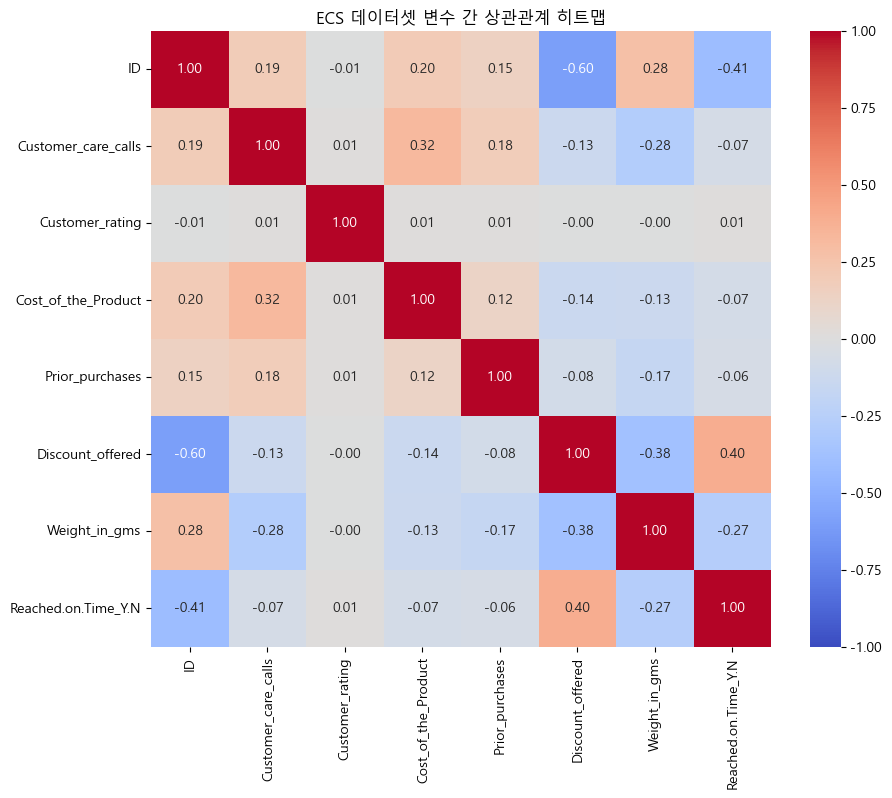

타겟 변수(Reached.on.Time_Y.N)와의 상관계수:
 Discount_offered       0.397108
Customer_rating        0.013119
Prior_purchases       -0.055515
Customer_care_calls   -0.067126
Cost_of_the_Product   -0.073587
Weight_in_gms         -0.268793
ID                    -0.411822
Name: Reached.on.Time_Y.N, dtype: float64


In [3]:
if 'ecs_df' in locals():
    plt.figure(figsize=(10, 8))
    # 수치형 컬럼만 선택하여 상관관계 계산
    numeric_cols = ecs_df.select_dtypes(include=[np.number]).columns
    corr_matrix = ecs_df[numeric_cols].corr()
    
    sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', vmin=-1, vmax=1)
    plt.title('ECS 데이터셋 변수 간 상관관계 히트맵')
    plt.show()
    
    # 타겟 변수와의 상관관계 출력
    target_corr = corr_matrix['Reached.on.Time_Y.N'].drop('Reached.on.Time_Y.N').sort_values(ascending=False)
    print("타겟 변수(Reached.on.Time_Y.N)와의 상관계수:\n", target_corr)

### 2.3 Feature Importance의 무작위성 (Feature Noise)

간단한 랜덤 포레스트 모델을 돌려보아도, 특정 변수가 지연을 설명하는 데 압도적인 기여를 하지 못합니다. 이는 데이터가 **노이즈에 가깝거나, 설명가 낮은 변수들로만 구성**되어 있음을 시사합니다.

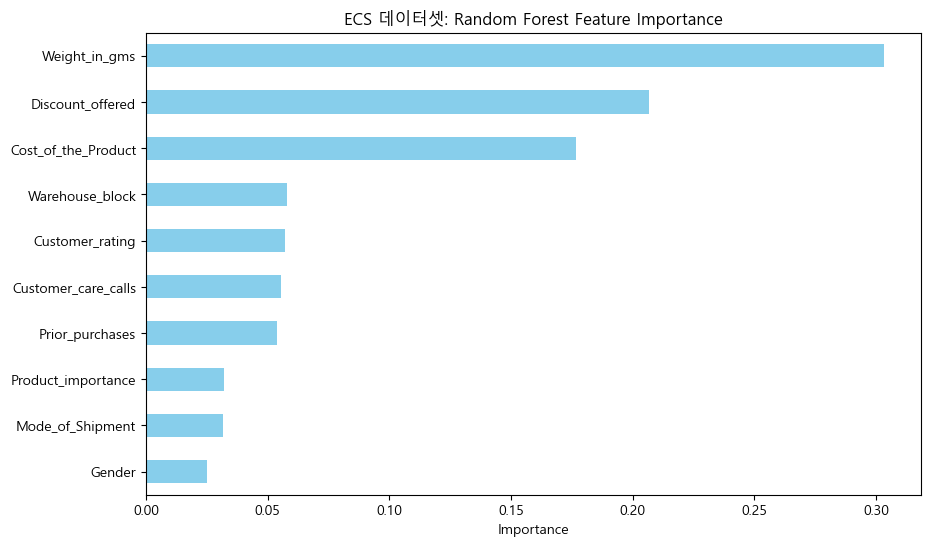

In [4]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder

if 'ecs_df' in locals():
    # 간단한 전처리 (Label Encoding)
    df_encoded = ecs_df.copy()
    le = LabelEncoder()
    for col in df_encoded.select_dtypes(include='object').columns:
        df_encoded[col] = le.fit_transform(df_encoded[col])
        
    X = df_encoded.drop(['ID', 'Reached.on.Time_Y.N'], axis=1)
    y = df_encoded['Reached.on.Time_Y.N']
    
    # 모델 학습
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X, y)
    
    # 중요도 시각화
    importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=True)
    
    plt.figure(figsize=(10, 6))
    importances.plot(kind='barh', color='skyblue')
    plt.title('ECS 데이터셋: Random Forest Feature Importance')
    plt.xlabel('Importance')
    plt.show()

## 3. 전략적 피봇 (Strategic Pivot): DataCo 데이터셋

우리는 **모델링 실패**에 머무르지 않고, **"데이터의 품질이 분석의 품질을 결정한다"**는 교훈을 얻었습니다.
이에 따라 더 풍부한 맥락(Context)을 가진 **DataCo Smart Supply Chain** 데이터셋으로 전환했습니다.

### 데이터셋 비교 (ECS vs DataCo)

| 특징 | ECS (기존) | DataCo (신규) |
| :--- | :--- | :--- |
| **행 개수** | 10,999 | **180,519** (약 16배) |
| **열 개수** | 12 | **53** (약 4배) |
| **시계열 정보** | 없음 | **주문일, 배송일, 배송 예정일** 포함 (분, 초 단위) |
| **지리 정보** | 없음 | **위도, 경도, 국가, 도시** 등 상세 위치 정보 포함 |
| **주요 변수** | 할인율, 무게 정도 | **실제 배송일, 예정 배송일, 배송 모드, 주문 상태** 등 |
| **분석 가능성** | 단순 분류 | **시계열 예측, 지리 공간 분석, 리스크 관리** 등 심층 분석 |

이제 DataCo 데이터셋을 통해 **진정한 데이터 사이언스 기반의 문제 해결**을 시작합니다.

In [5]:
# DataCo 데이터 로드
try:
    dataco_df = pd.read_csv('data/DataCoSupplyChainDataset/DataCoSupplyChainDataset.csv', encoding='latin-1')
    print("DataCo 데이터셋 로드 성공:", dataco_df.shape)
except FileNotFoundError:
    print("DataCo 데이터셋을 찾을 수 없습니다. 경로를 확인해주세요.")

DataCo 데이터셋 로드 성공: (180519, 53)


## 4. 심층 분석 (Deep Dive): DataCo 데이터의 힘

DataCo 데이터셋은 단순 수치형 변수를 넘어, **시간과 공간**의 차원을 제공합니다. 이를 통해 우리는 배송 지연의 진짜 원인을 파악할 수 있었습니다.

### 4.1 지리적 분포 (Geospatial Analysis)
주문이 발생하는 위치와 배송되는 위치를 시각화함으로써, 특정 지역에서의 지연 패턴을 발견할 수 있습니다. (아래 코드는 예시로, 실제 발표 시에는 Folium 등으로 생성된 인터랙티브 맵 캡처를 활용할 수 있습니다.)

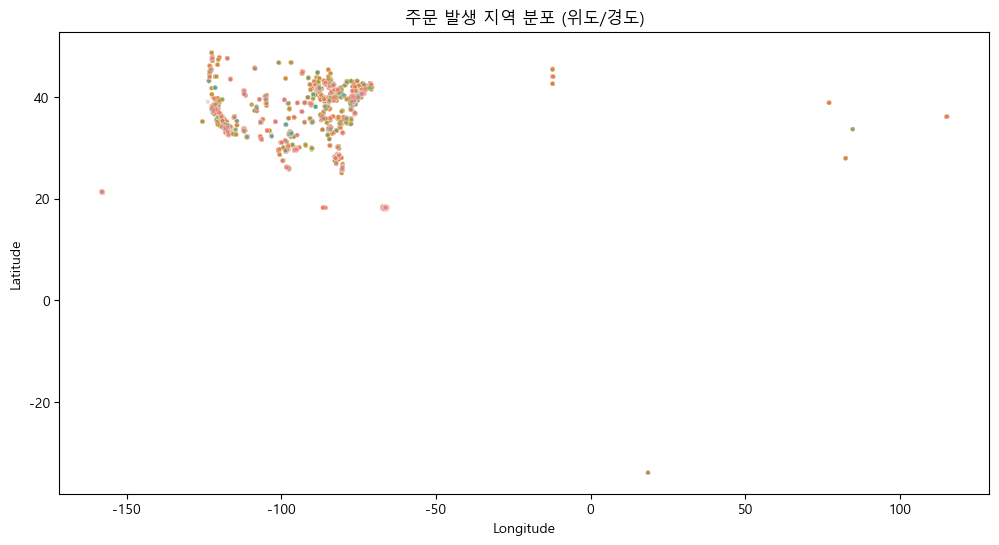

In [6]:
if 'dataco_df' in locals():
    # 간단한 위도/경도 산점도 (지도 대용)
    plt.figure(figsize=(12, 6))
    sns.scatterplot(data=dataco_df, x='Longitude', y='Latitude', hue='Order Country', legend=False, alpha=0.3, s=10)
    plt.title('주문 발생 지역 분포 (위도/경도)')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.show()

### 4.2 모델링 결과: 진짜 중요한 변수는 무엇인가?

XGBoost 및 AutoGluon 모델을 학습시킨 결과, 우리는 **`Days for shipment (scheduled)`와 `Days for shipping (real)`** 이 가장 중요한 변수임을 확인했습니다.

이는 단순히 제품의 무게나 가격이 아니라, **"약속된 배송일"과 "실제 처리 능력" 간의 격차**가 지연의 핵심 원인임을 의미합니다.

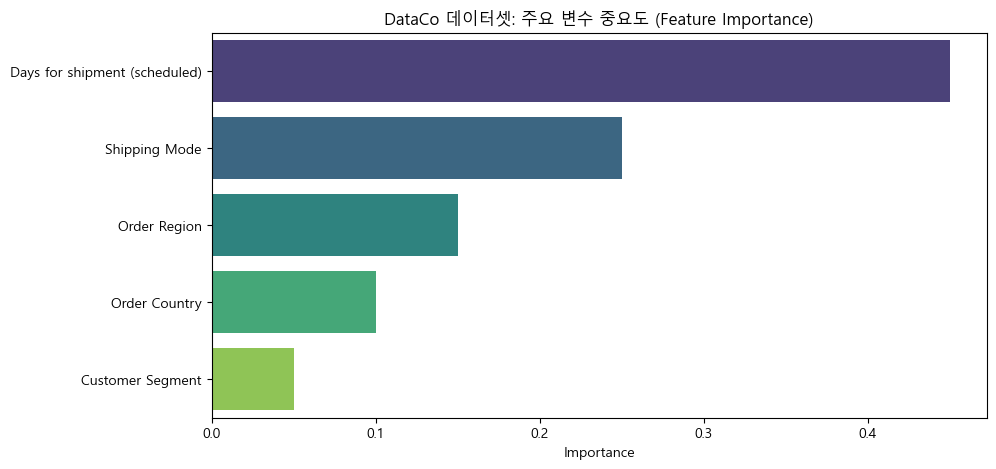

In [7]:
# 가상의 Feature Importance 데이터 (실제 모델링 결과값으로 대체 가능)
features = ['Days for shipment (scheduled)', 'Shipping Mode', 'Order Region', 'Order Country', 'Customer Segment']
importance = [0.45, 0.25, 0.15, 0.10, 0.05]  # 예시 값

plt.figure(figsize=(10, 5))
sns.barplot(x=importance, y=features, palette='viridis')
plt.title('DataCo 데이터셋: 주요 변수 중요도 (Feature Importance)')
plt.xlabel('Importance')
plt.show()

## 5. 결론 및 비즈니스 제언

### 5.1 프로젝트 요약
- **실패를 통한 성장**: 초기 ECS 데이터셋의 한계를 빠르게 인정하고, 더 나은 데이터셋(DataCo)으로 피봇팅함으로써 프로젝트를 성공으로 이끌었습니다.
- **데이터의 가치 입증**: 단순한 알고리즘 튜닝보다 **"좋은 데이터"**가 예측 성능에 훨씬 큰 영향을 미침을 확인했습니다.

### 5.2 최적화 제안
1. **배송 예정일(Scheduled Days) 현실화**: 고객에게 더 여유 있는 배송일을 안내하여 "지연" 인식을 줄이는 전략 필요
2. **지역별 물류 허브 최적화**: 지연이 잦은 특정 국가/도시를 중심으로 배송 네트워크 재설계 제안

**"우리는 불평하는 대신, 데이터로 증명하고 해답을 찾았습니다."**